In [1]:
%run Imports.ipynb
from quantpy.tomography.interval import ConfidenceInterval, _pop_hidden_keys, Mode

import numpy as np
import scipy.linalg as la
import scipy.stats as sts
import polytope as pc
import math
import pypoman

from enum import Enum, auto
from abc import ABC, abstractmethod
from scipy.interpolate import interp1d
from collections import Counter, defaultdict
from functools import partial
from cvxopt import matrix, solvers

from quantpy.geometry import hs_dst, trace_dst, if_dst
from quantpy.polytope import compute_polytope_volume, find_max_distance_to_polytope
from quantpy.qobj import Qobj
from quantpy.routines import (
    _left_inv, _vec2mat, _mat2vec,
    _matrix_to_real_tril_vec, _real_tril_vec_to_matrix,
)

## States

In [2]:
class WangIntervalFidelity(ConfidenceInterval):    
    def __init__(self, tmg, n_points=1000, target_state=None):
        kwargs = _pop_hidden_keys(locals())
        super().__init__(tmg, **kwargs)
        
    def __call__(self, conf_levels=None):
        if conf_levels is None:
            conf_levels = np.linspace(1e-3, 1-1e-3, 1000)
        if not hasattr(self, 'cl_to_dist_max'):
            self.setup()
        return (self.cl_to_dist_min(conf_levels), self.cl_to_dist_max(conf_levels)), conf_levels

    def setup(self):
        if self.mode == Mode.CHANNEL:
            raise NotImplementedError("This interval works only for state tomography")
            
        if self.target_state is None:
            self.target_state = self.tmg.state
        
        dim = 2 ** self.tmg.state.n_qubits
        frequencies = np.clip(self.tmg.raw_results / self.tmg.n_measurements[:, None], self.EPS, 1 - self.EPS)

        povm_matrix = (np.reshape(self.tmg.povm_matrix * self.tmg.n_measurements[:, None, None]
                                  / np.sum(self.tmg.n_measurements),
                                  (-1, self.tmg.povm_matrix.shape[-1]))
                       * self.tmg.povm_matrix.shape[0])
        A = np.ascontiguousarray(povm_matrix[:, 1:]) * dim
        
        max_delta = count_delta(1-1e-5, frequencies, self.tmg.n_measurements)
        min_delta = count_delta(0, frequencies, self.tmg.n_measurements)
        deltas = np.linspace(min_delta, max_delta, self.n_points)
        
        dist_max = []
        dist_min = []
        for delta in deltas:
            b = np.clip(np.hstack(frequencies) + delta, self.EPS, 1 - self.EPS) - povm_matrix[:, 0]
            c = matrix(self.target_state.bloch[1:])
            G, h = matrix(A), matrix(b)
            sol = solvers.lp(c, G, h)
            if not sol['primal objective']:
                dist_min.append(1)
            else:
                dist_min.append(1/dim + sol['primal objective'] * dim)
            sol = solvers.lp(-c, G, h)
            if not sol['primal objective']:
                dist_max.append(1)
            else:
                dist_max.append(1/dim - sol['primal objective'] * dim)
        
        conf_levels = []
        for delta in deltas:
            conf_levels.append(count_confidence(delta, frequencies, self.tmg.n_measurements))
        self.cl_to_dist_max = interp1d(conf_levels, dist_max)
        self.cl_to_dist_min = interp1d(conf_levels, dist_min)
    
    
def count_confidence(delta, frequencies, n_measurements):
    EPS = 1e-15
    freq_plus_delta = np.clip(frequencies + delta, EPS, 1 - EPS)
    KL_divergence = (frequencies * np.log(frequencies / freq_plus_delta)
                     + (1 - frequencies) * np.log(
                (1 - frequencies) / (1 - freq_plus_delta)))
    KL_divergence = np.where(freq_plus_delta < 1 - EPS, KL_divergence, np.inf)
    epsilons = np.exp(-n_measurements[:, None] * KL_divergence)
    epsilons = np.where(np.abs(frequencies - 1) < 2 * EPS, 0, epsilons)
    return np.prod(np.maximum(1 - np.sum(epsilons, axis=-1), 0))

def count_delta(target_cl, frequencies, n_measurements):
    EPS = 1e-10
    left = 1e-10
    right = 1
    while right - left > 1e-10:
        delta = (left + right) / 2
        confidence = count_confidence(delta, frequencies, n_measurements)
        if confidence < target_cl + EPS:
            left = delta
        else:
            right = delta
    return delta

In [3]:
target_state = qp.qobj.GHZ(2)
dep_channel = qp.channel.depolarizing(0.1, 2)
state = dep_channel.transform(target_state)

tmg = qp.StateTomograph(state)
tmg.experiment(10000)
state_hat = tmg.point_estimate()
fidelity = 1 - qp.if_dst(target_state, state)
interval = WangIntervalFidelity(tmg, target_state=target_state)
(dist_min, dist_max), conf_levels = interval()

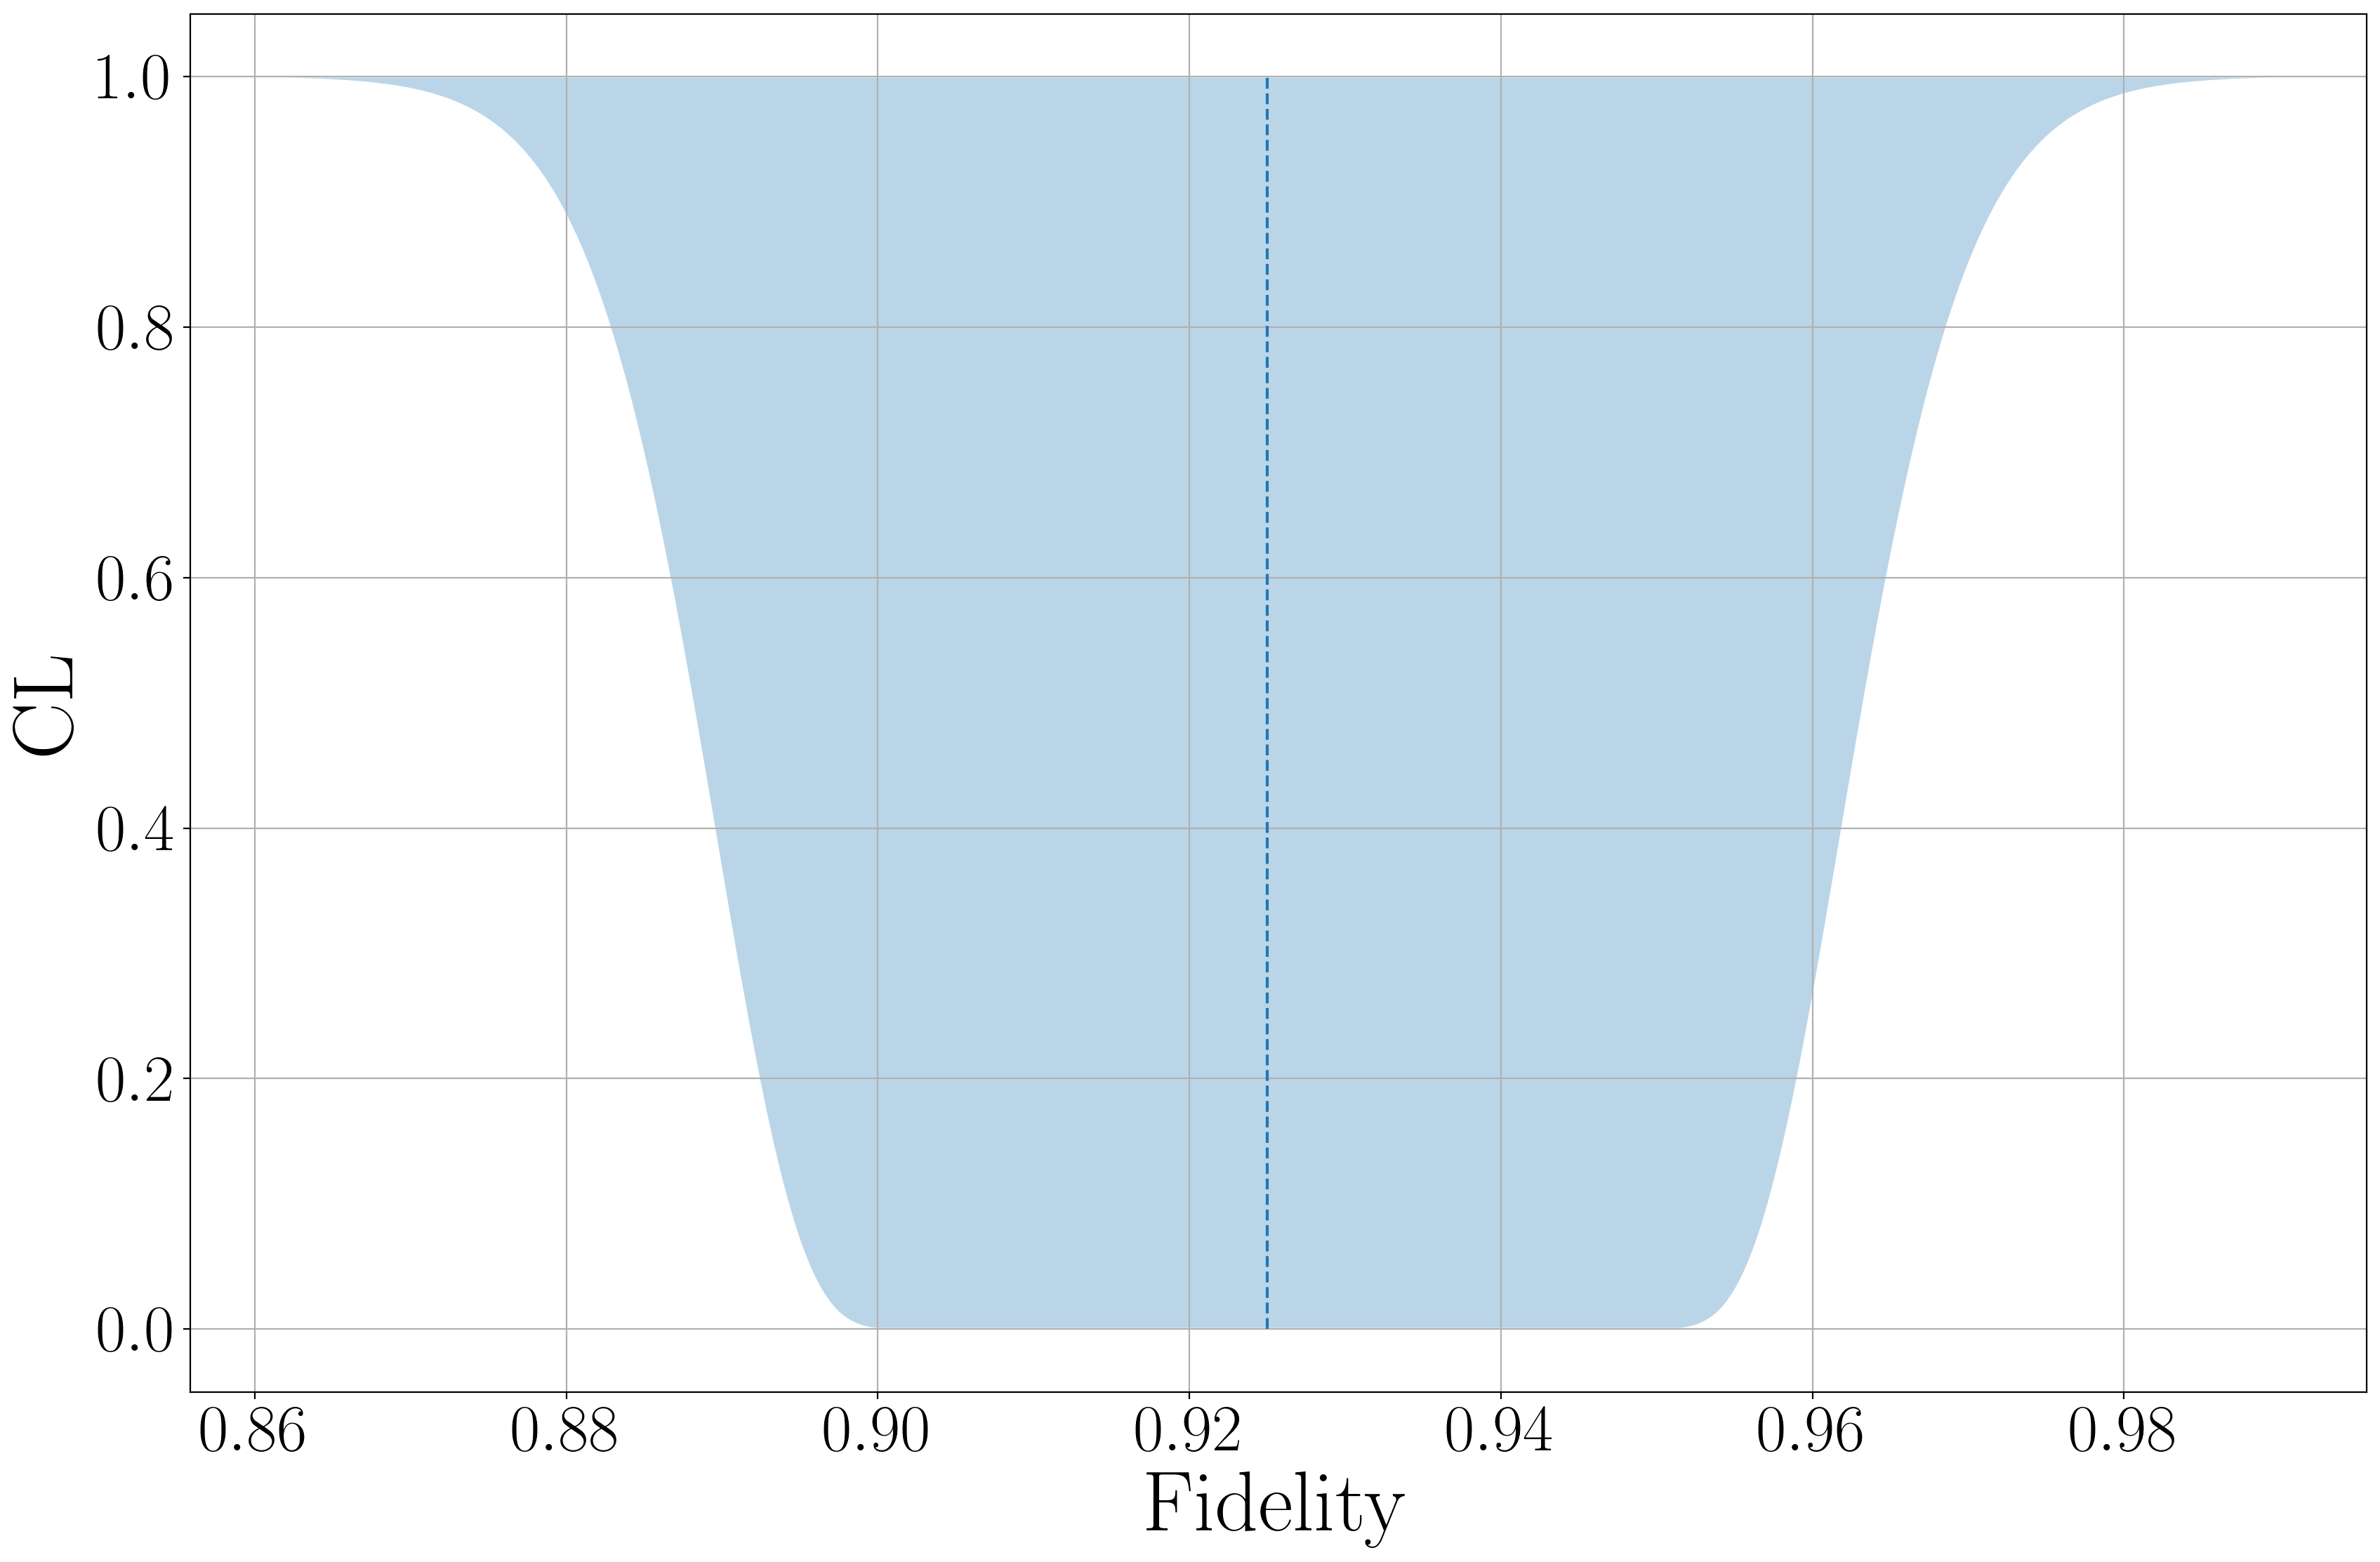

In [4]:
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('Fidelity')
plt.ylabel('CL')
plt.grid()
plt.fill_betweenx(conf_levels, dist_min, dist_max, alpha=0.3)
plt.plot([fidelity] * 2, [0, 1], '--')

## Processes

In [10]:
class ProcessWangIntervalFidelity(ConfidenceInterval):
    def __init__(self, tmg, n_points=1000, target_channel=None):
        kwargs = _pop_hidden_keys(locals())
        super().__init__(tmg, **kwargs)
        
    def __call__(self, conf_levels=None):
        if conf_levels is None:
            conf_levels = np.linspace(1e-3, 1-1e-3, 1000)
        if not hasattr(self, 'cl_to_dist_max'):
            self.setup()
        return (self.cl_to_dist_min(conf_levels), self.cl_to_dist_max(conf_levels)), conf_levels
        
    def setup(self):
        channel = self.tmg.channel
        dim = 4 ** channel.n_qubits
        bloch_dim = dim ** 2 - dim
        
        if self.target_channel is None:
            self.target_channel = channel
        
        povm_matrix = self.tmg.tomographs[0].povm_matrix
        n_measurements = self.tmg.tomographs[0].n_measurements

        frequencies = np.asarray([
            np.clip(tmg.raw_results / tmg.n_measurements[:, None], self.EPS, 1 - self.EPS)
            for tmg in self.tmg.tomographs
        ])
        
        eta_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                                  (-1, povm_matrix.shape[-1])) 
                       * povm_matrix.shape[0])
        Rt = np.asarray([rho.T.bloch for rho in self.tmg.input_basis.elements])
        pi_matrix = np.einsum("ij,ab->iajb", Rt, eta_matrix)
        pi_matrix = pi_matrix.reshape((pi_matrix.shape[0] * pi_matrix.shape[1],
                                       pi_matrix.shape[2] * pi_matrix.shape[3]))
        A = np.ascontiguousarray(pi_matrix[:, dim:]) * dim
        
        max_delta = count_delta(1-1e-5, frequencies, n_measurements)
        min_delta = count_delta(0, frequencies, n_measurements)
        deltas = np.linspace(min_delta, max_delta, self.n_points)
        
        dist_max = []
        dist_min = []
        for delta in deltas:
            b = (np.clip(np.hstack(np.concatenate(frequencies, axis=0)) + delta, self.EPS, 1 - self.EPS) 
                 - pi_matrix[:, 0] * 2 ** channel.n_qubits)
            c = matrix(self.target_channel.choi.bloch[dim:])
            G, h = matrix(A), matrix(b)
            sol = solvers.lp(c, G, h)
            if not sol['primal objective']:
                dist_min.append(1)
            else:
                dist_min.append(1/dim + sol['primal objective'])
            sol = solvers.lp(-c, G, h)
            if not sol['primal objective']:
                dist_max.append(1)
            else:
                dist_max.append(1/dim - sol['primal objective'])

        conf_levels = []
        for delta in deltas:
            conf_levels.append(count_confidence(delta, frequencies, self.tmg.tomographs[0].n_measurements))
        self.cl_to_dist_max = interp1d(conf_levels, dist_max)
        self.cl_to_dist_min = interp1d(conf_levels, dist_min)

In [11]:
target_channel = qp.channel.depolarizing(0, 1)
channel = qp.channel.depolarizing(0.1, 1)

dim = 4 ** channel.n_qubits
tmg = qp.ProcessTomograph(channel, input_states='sic')
tmg.experiment(10000)
channel_hat = tmg.point_estimate()
fidelity = np.dot(target_channel.choi.bloch, channel.choi.bloch)
interval = ProcessWangIntervalFidelity(tmg, target_channel=target_channel)
(dist_min, dist_max), conf_levels = interval()

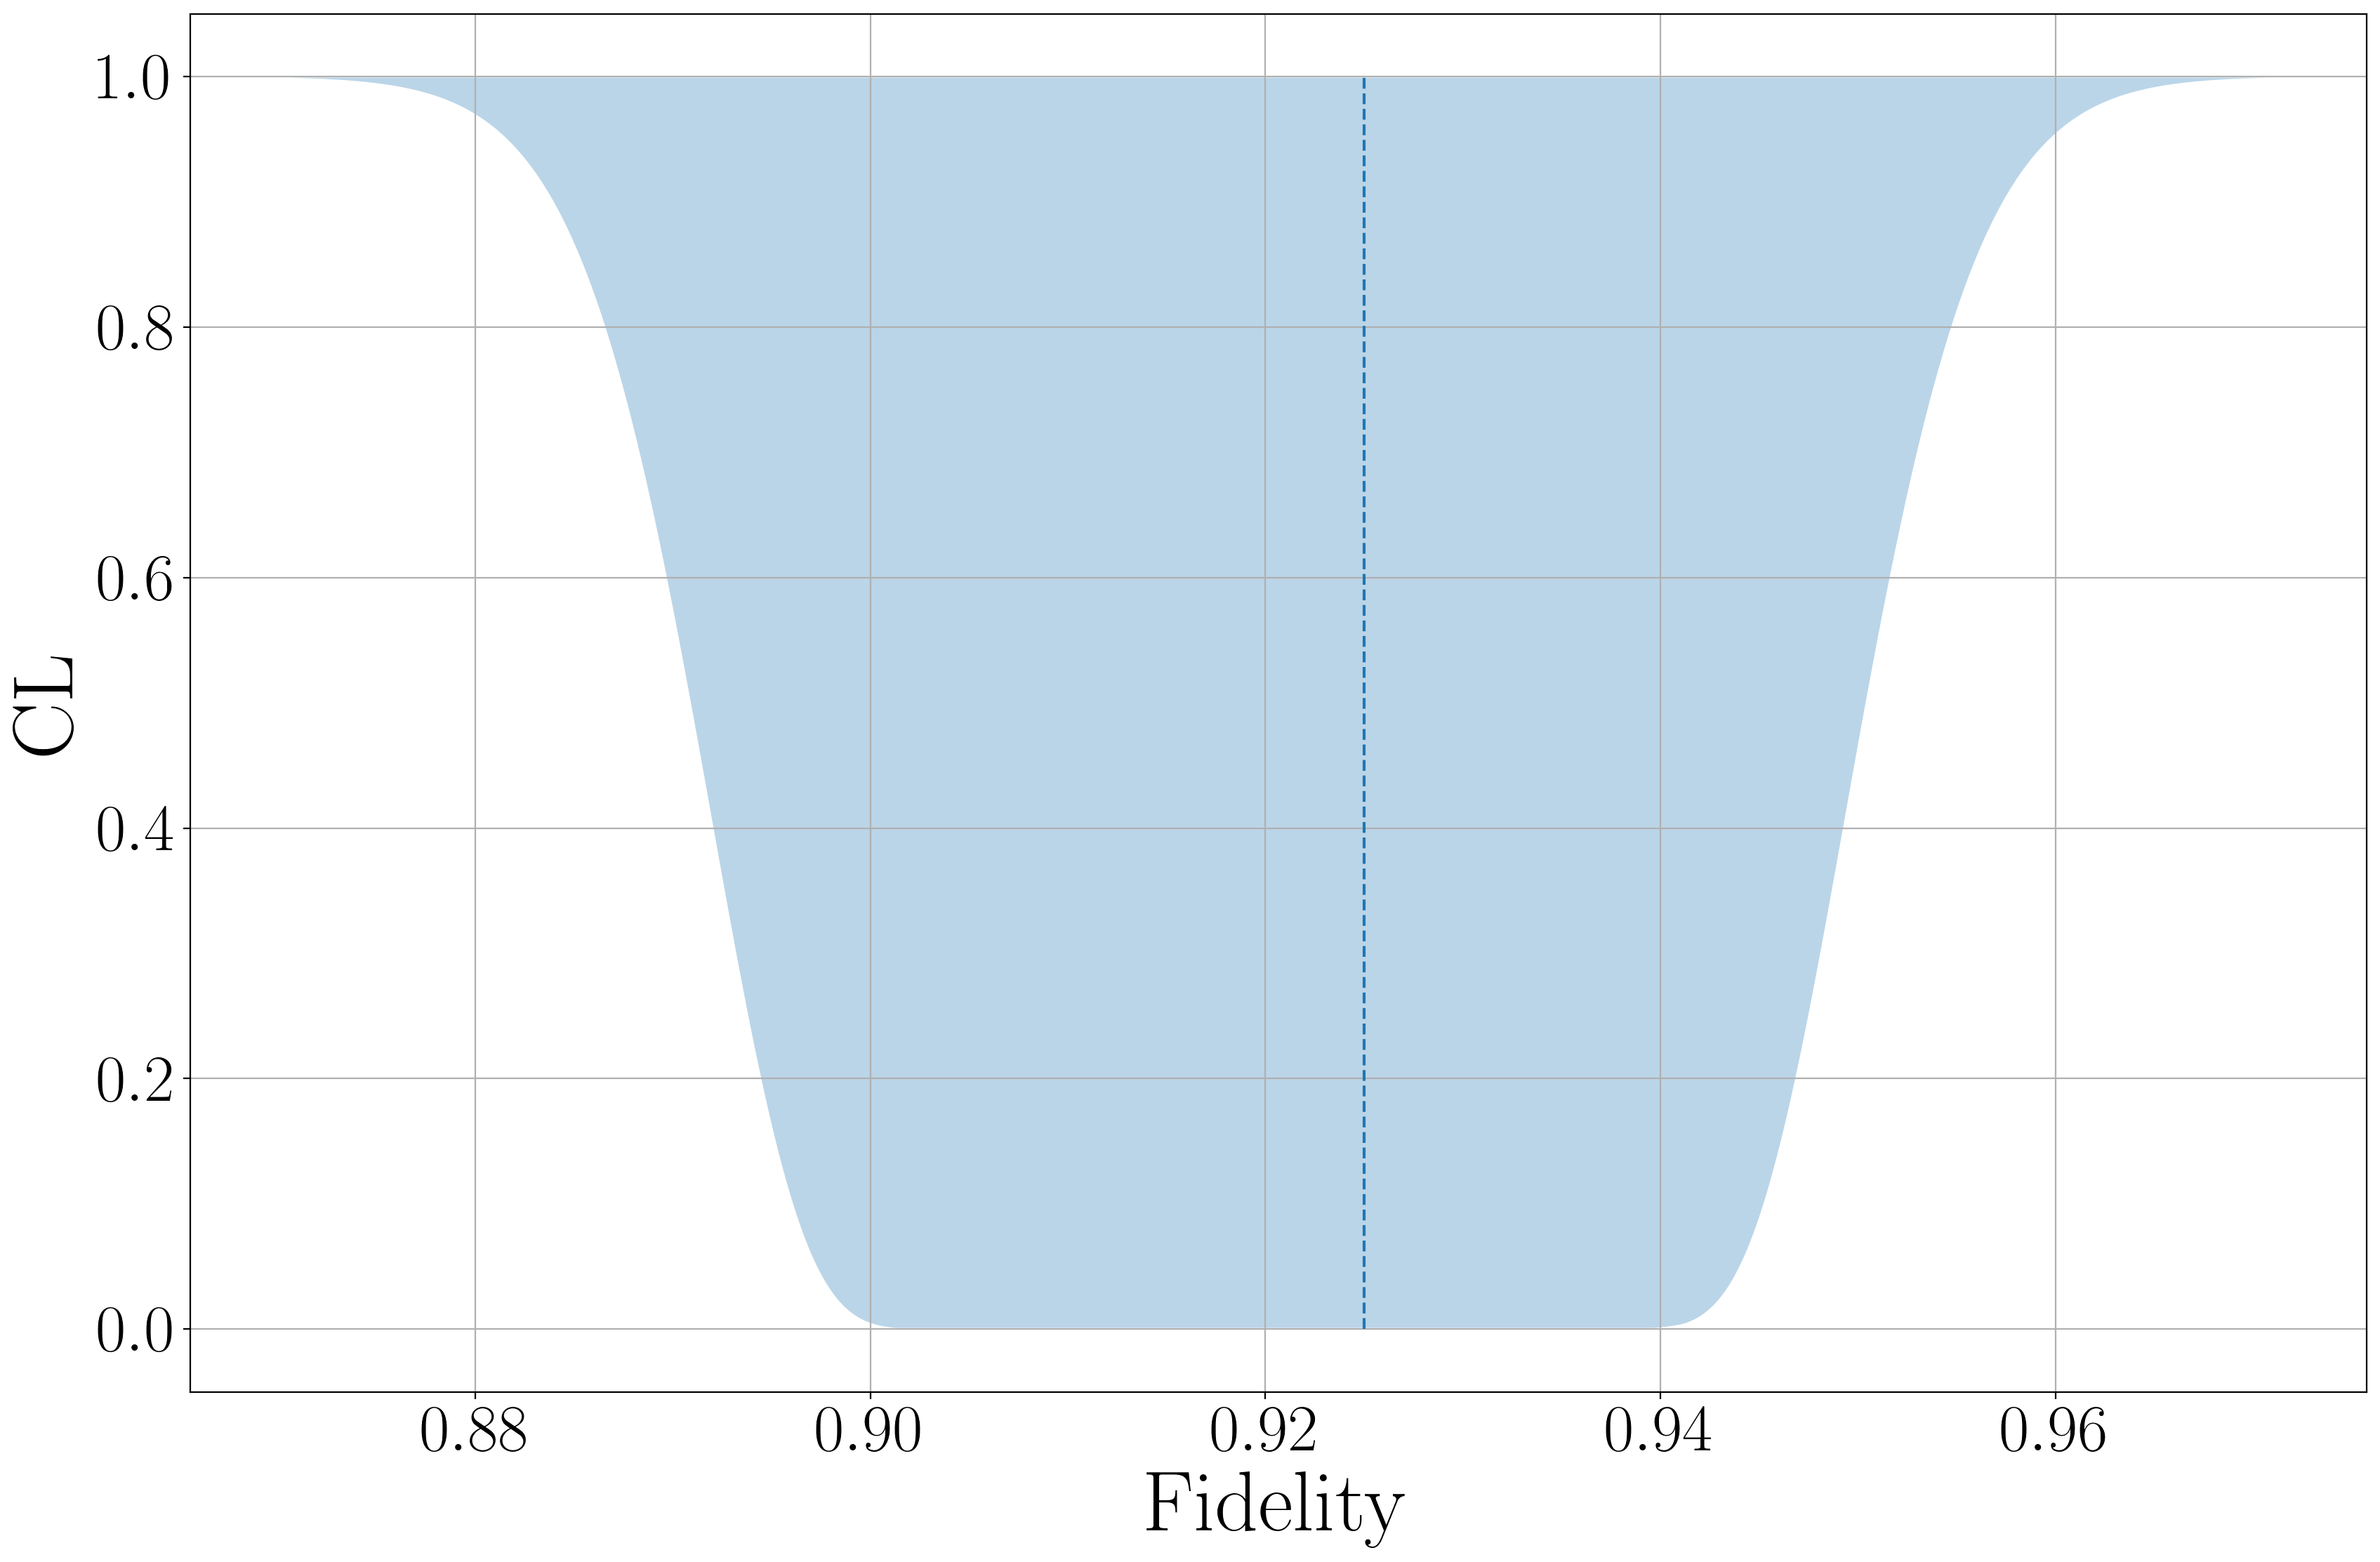

In [12]:
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('Fidelity')
plt.ylabel('CL')
plt.grid()
plt.fill_betweenx(conf_levels, dist_min, dist_max, alpha=0.3)
plt.plot([fidelity] * 2, [0, 1], '--')

## Sandbox

In [100]:
# state = qp.Qobj([1, 0, 0, 0], is_ket=True)
state = qp.Qobj([0, 0, 0.5])
# state = qp.qobj.GHZ(3)
tmg = qp.StateTomograph(state)
tmg.experiment(10000)
state_hat = tmg.point_estimate()
interval = WangIntervalFidelity(tmg)
dist, CLs = interval()

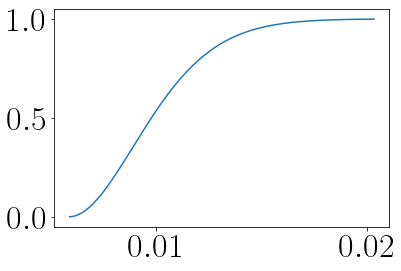

In [102]:
plt.plot(dist, CLs)

In [242]:
target_channel = qp.channel.depolarizing(0, 1)
channel = qp.channel.depolarizing(0.1, 1)

dim = 4 ** channel.n_qubits
tmg = qp.ProcessTomograph(channel, input_states='sic')
tmg.experiment(10000)
channel_hat = tmg.point_estimate()
true_if_dst = 1 - np.dot(target_channel.choi.bloch, channel.choi.bloch)
EPS = 1e-15

povm_matrix = tmg.tomographs[0].povm_matrix
n_measurements = tmg.tomographs[0].n_measurements

eta_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                          (-1, povm_matrix.shape[-1])) 
               * povm_matrix.shape[0])
Rt = np.asarray([rho.T.bloch for rho in tmg.input_basis.elements])
pi_matrix = np.einsum("ij,ab->iajb", Rt, eta_matrix)
pi_matrix = pi_matrix.reshape((pi_matrix.shape[0] * pi_matrix.shape[1],
                               pi_matrix.shape[2] * pi_matrix.shape[3]))
A = np.ascontiguousarray(pi_matrix[:, dim:]) * dim

n_trials = 100
step = 0.03
conf_levels = [0.1, 0.5, 0.75, 0.9, 0.95, 0.99]

# true_if_dst = []
min_if_dst = defaultdict(list)
max_if_dst = defaultdict(list)
for _ in tqdm(range(n_trials)):
    tmg = qp.ProcessTomograph(channel, input_states='sic')
    tmg.experiment(n_measurements)
    channel_hat = tmg.point_estimate('lifp')
    frequencies = np.asarray([
        np.clip(ptmg.raw_results / ptmg.n_measurements[:, None], EPS, 1 - EPS)
        for ptmg in tmg.tomographs
    ])
#     true_if_dst.append(1 - np.dot(channel_hat.choi.bloch, target_channel.choi.bloch))
    for i, cl in enumerate(conf_levels):
        delta = count_delta(cl, frequencies, tmg.tomographs[0].n_measurements)
        b = (np.clip(np.hstack(np.concatenate(frequencies, axis=0)) + delta, EPS, 1 - EPS) 
             - pi_matrix[:, 0] * 2 ** channel.n_qubits)
        c = matrix(target_channel.choi.bloch[dim:])
        G, h = matrix(A), matrix(b)
        sol = solvers.lp(c, G, h)
        max_if_dst[cl].append((dim-1)/dim - sol['primal objective'])
        sol = solvers.lp(-c, G, h)
        min_if_dst[cl].append((dim-1)/dim + sol['primal objective'])

In [230]:
np.mean(true_if_dst), np.std(true_if_dst)

(0.07499312021278137, 0.00011937052692535277)

In [231]:
list(map(np.mean, min_if_dst.values()))

[0.07421942739518324,
 0.07405540807400648,
 0.07394789387581548,
 0.07383620415485805,
 0.07376217972470357,
 0.07360882614426686]

In [232]:
list(map(np.mean, max_if_dst.values()))

[0.07576669764759253,
 0.07593127378667859,
 0.07603852454061034,
 0.07615003681508065,
 0.07622406167865306,
 0.07637741717021157]

In [233]:
list(map(np.std, min_if_dst.values()))

[0.00012216280038022655,
 0.00012041162200393123,
 0.00011964515417207543,
 0.00011929564519926481,
 0.00011929210047071628,
 0.00011928361967273548]

In [234]:
list(map(np.std, max_if_dst.values()))

[0.00011928781179163028,
 0.00011942671632017003,
 0.00011943764692424908,
 0.0001194477900127187,
 0.0001194545775971745,
 0.00011946077503377002]

In [235]:
min_if_dst

defaultdict(list,
            {0.1: [0.07420800295464469,
              0.07431887397547288,
              0.07415196883788144,
              0.07425494032968027,
              0.07411055667387778,
              0.07423863531309194,
              0.07432602479993422,
              0.07400434059519057,
              0.07417858204072769,
              0.07417140018500334,
              0.07416783325756782,
              0.07428286166769316,
              0.07429556120858916,
              0.07395875822318865,
              0.07454504478901447,
              0.07424548975714673,
              0.07418951750304825,
              0.07408476382686668,
              0.0741441136858847,
              0.07425099202064633,
              0.07416760538055567,
              0.07424281101925345,
              0.07429117820656761,
              0.07434479392694937,
              0.07425582636377814,
              0.07390967366267032,
              0.07427788734150731,
              0.07396668353032443

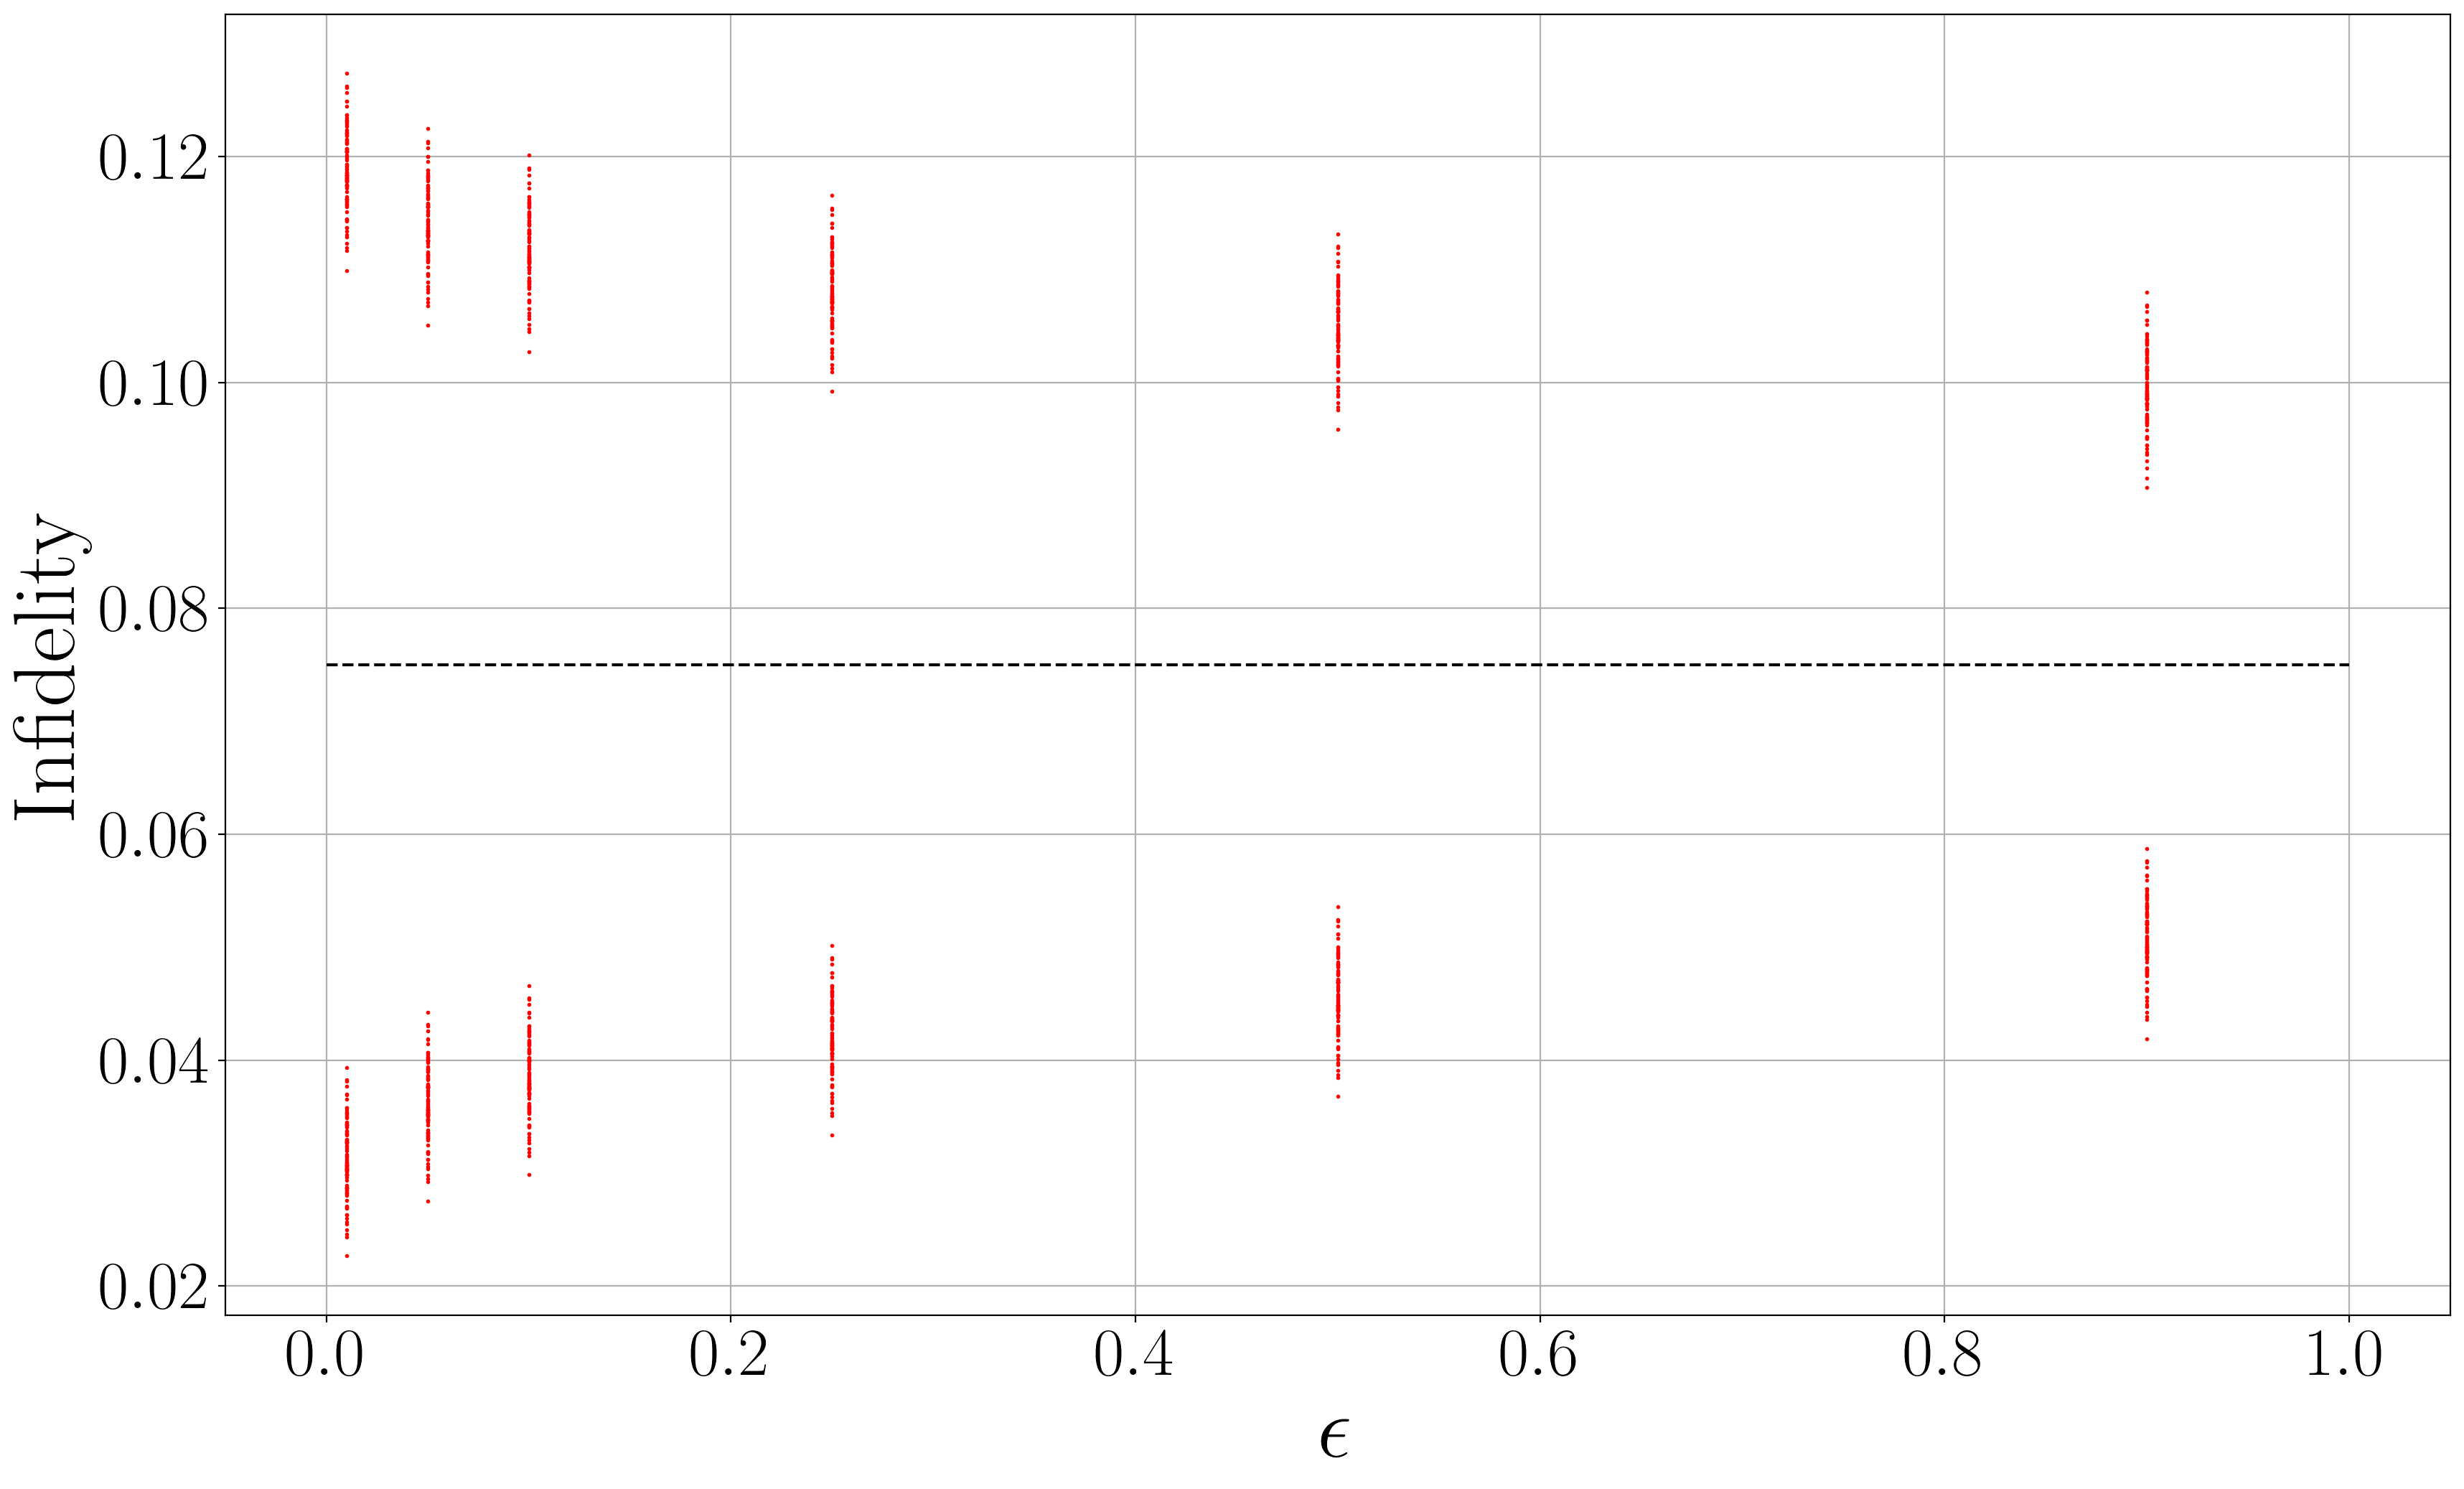

In [243]:
plt.figure(figsize=(20, 12), dpi=200)
plt.grid()
plt.xlabel('$\\epsilon$')
plt.ylabel('Infidelity')
for cl, values in min_if_dst.items():
    epsilons = np.ones(len(values)) * (1 - cl)
    plt.plot(epsilons, values, 'ro', ms=1)
for cl, values in max_if_dst.items():
    epsilons = np.ones(len(values)) * (1 - cl)
    plt.plot(epsilons, values, 'ro', ms=1)
plt.plot([0, 1], [true_if_dst] * 2, '--k')